# Модель микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

#### Дополнительные блокноты для работы с этой моделью

  - <a href="bankrupt_prob_prepare.ipynb" target="_blank">Блокнот Jupyter для работы с промежуточными моделями и подготовки массива данных для основной модели</a>  
  - <a href="bankrupt_prob_DB.ipynb" target="_blank">Блокнот Jupyter для работы с базой данных для промежуточнымх моделей</a>


### Основная модель (вероятность банкротства для **отдельной** компании:       
<br>
 <center>$Y_i^j$ ~ $ROA\_{par}_{i-1}^j + Z\_A\_{par}_{i-1}^j + LOAN\_{par}_{i-1}^j + \log_{10}(capital_i^j) + 1$</center>
 
 
где $ i - \text{индекс года};  j - \text{индекс компании} $
 
#### Предикторы:
- Ставка по кредитам для компании j ($LOAN\_{par}^j$ с лагом 1 год)
- Рентабельность застройщика j ($ROA\_{par}^j$ с лагом 1 год)
- Чистая кредиторская задолженность компании j ($Z_A\_{par}^j$ с лагом 1 год)
- Уставной капитал компании j, $ln$ ($capital^j$)

#### Объясняемая переменная:
- флаг банкротства компании j, устанавливаемый в год банкротства ($Y^j$ = 1 означает, что компания - банкрот)

#### Параметры:
- Переменная `fBnkrp_Level` задает порог отсечки события (превышение порога - предприятие банкрот).
- `iLastFactYEAR` - последний год фактических данных. Выбирается максимальный год из таблицы SPARK.
- `iLastFORCAST` - год горизонта прогноза. Устанавливается $iLastFORCAST = iLastFactYEAR + 3$ но можно задать вручную. 
 
**Модель оценивается на фактических значениях**

In [20]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy
import datetime as dt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('..', 'DB', 'bankrp.sqlite3')

# константы базы данных SQLite3
strSRC_data='model_data' # название таблицы с исходными данными для модели
strNOZA_agg='noza_ag' # название рабочего  представления для таблицы NOZA в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strNOZA_table='noza' # название таблицы NOZA в базе данных SQLite
strInfoTable='update_info' # таблица с информацией об обновлении базы даных

# ------------

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных

iFirstFactYear=2010 
iLastFactYEAR = conWork.connect().execute('select max(year) from spark').fetchone()[0]
strMainDataUpdateDate=conWork.connect().execute('''select udate from {tab_info} 
where utable == "{tab_model}"'''.format(tab_info=strInfoTable, tab_model=strSRC_data)).fetchone()[0]

strLastYEarFactBNKR=conWork.connect().execute('select MAX(year) from "{tab_model}" where Y==1'.format(tab_model=strSRC_data)).fetchone()[0]

iLastFORCAST=iLastFactYEAR+3
fBnkrp_Level=7e-3

print('Первый фактический год (из базы СПАРК):', iFirstFactYear, '\nПоследний фактический год (из базы СПАРК):', iLastFactYEAR, 
      '\nГоризонт прогноза:', iLastFORCAST, '\nОтсечка - ', fBnkrp_Level)
print("-"*50)
print('Данные для модели пересчитаны: ', strMainDataUpdateDate)
print('Последний год с фактическими данными по банкротсвам (из базы с фактическими банкротствами): ', strLastYEarFactBNKR)

Первый фактический год (из базы СПАРК): 2010 
Последний фактический год (из базы СПАРК): 2019 
Горизонт прогноза: 2022 
Отсечка -  0.007
--------------------------------------------------
Данные для модели пересчитаны:  2020-12-18
Последний год с фактическими данными по банкротсвам (из базы с фактическими банкротствами):  2020


## Подготовка данных
 
Исходные данные для модели - в таблице `model_data` базы данных. 
В этой таблице предикторы модели продлены на прогнозный период при помощи данных, полученных от промежуточных моделей (экстраполяция).   

In [21]:
strSelectDATA='select * from {}'.format(strSRC_data)

pdf_Data=pd.read_sql(strSelectDATA, con=conWork).set_index(['inn', 'year'])
pdf_Data

ROA_par   Z_A_par       capital    Y   LOAN_par
inn        year                                                  
0104014512 2014 -0.042600  0.797872  1.000000e+04  0.0  11.135000
           2015  0.004100  0.960739  1.000000e+04  0.0  15.716667
           2016  0.001500  0.255651  1.000000e+04  0.0  12.592500
           2017  0.052300  0.190691  4.000000e+07  0.0  10.560000
           2018  0.001100  0.178391  4.000000e+07  0.0   8.866667
...                   ...       ...           ...  ...        ...
9729055420 2021  0.002250  0.033804  4.000020e+09  0.0   4.725591
           2022  0.001202  0.031894  4.000020e+09  0.0   6.327573
           2023  0.002394  0.032195  4.000020e+09  0.0   6.569880
           2024  0.001658  0.032027  4.000020e+09  0.0   6.812186
           2025  0.001787  0.032027  4.000020e+09  0.0   6.626160

[59251 rows x 5 columns]

<div class="alert alert-block alert-info">
    <b>
    X - предикторы фактических значений<br>
    Y - известные объясняемые значения<br>
        <hr>
    x - предикторы прогнозных значений<br>
    y - прогнозные объясняемые значения<br>
        <br>
    Прогнозные значения вероятностей банкротств считаются на основе, но не по регрессионной модели - см. ниже
    </b>
</div>

<div class="alert alert-block alert-warning">
В модели используются лаги по годам. Однако, поскольку во фрейме испльзуется двойная индексация, и лаги идут внутри данных застройщика (сдвигаем годы внутри inn), использовать сдвиги внутри формулы, задающей регрессию, нельзя (там сдвигается целиком массив данных).   
Следовательно, сдвигаем входные данные во входном фрейме - они будут в полях <b>ROA_par_shift, Z_A_par_shift</b> и <b>LOAN_par_shift</b>` соответственно.<br>
<b>Сдвиг = 1 (текущий год идет на следующий)</b>
</div>



In [22]:
pdf_Data[['ROA_par_shift', 'Z_A_par_shift', 'LOAN_par_shift']]=pdf_Data.groupby(level=0)[['ROA_par', 'Z_A_par', 'LOAN_par']].shift(1)

# pdf_Data[['ROA_par_shift', 'Z_A_par_shift', 'LOAN_par_shift']]=pdf_Data[['ROA_par', 'Z_A_par', 'LOAN_par']]

pdf_XY=pdf_Data.loc[idx[:, iFirstFactYear:iLastFactYEAR], :].copy()
# pdf_xy=pdf_Data.loc[idx[:, iLastFactYEAR:iLastFORCAST+1], :].copy()


pdf_XY=pdf_XY.dropna()
# pdf_xy=pdf_xy.dropna()

pdf_XY

ROA_par   Z_A_par       capital    Y   LOAN_par  \
inn        year                                                    
0104014512 2015   0.0041  0.960739  1.000000e+04  0.0  15.716667   
           2016   0.0015  0.255651  1.000000e+04  0.0  12.592500   
           2017   0.0523  0.190691  4.000000e+07  0.0  10.560000   
           2018   0.0011  0.178391  4.000000e+07  0.0   8.866667   
           2019   0.0006  0.082383  2.495000e+06  0.0   8.753333   
...                  ...       ...           ...  ...        ...   
9718003519 2017  -0.0020  0.574666  1.011953e+09  0.0  10.560000   
           2018  -0.0237  0.604968  1.011953e+09  0.0   8.866667   
           2019  -0.0091  0.570066  1.011953e+09  0.0   8.753333   
9729055420 2018  -0.0329  0.149134  4.000020e+09  0.0   8.866667   
           2019  -0.0012  0.037831  4.000020e+09  0.0   8.753333   

                 ROA_par_shift  Z_A_par_shift  LOAN_par_shift  
inn        year                                                
0104014512 2015        -0.0426       0.797872       11.135000  
           2016         0.0041       0.960739       15.716667  
           2017         0.0015       0.255651       12.592500  
           2018         0.0523       0.190691       10.560000  
           2019         0.0011       0.178391        8.866667  
...                        ...            ...             ...  
9718003519 2017        -0.0003       0.005683       12.592500  
           2018        -0.0020       0.574666       10.560000  
           2019        -0.0237       0.604968        8.866667  
9729055420 2018         0.0016       0.502095       10.560000  
           2019        -0.0329       0.149134        8.866667  

[23915 rows x 8 columns]

### Оценка регрессионой модели

In [23]:
from statsmodels.discrete.conditional_models import ConditionalLogit
bnkr_model = smf.logit("Y ~ LOAN_par_shift + ROA_par_shift + Z_A_par_shift + np.log(capital) + 1", data=pdf_XY)

# это модель с группами, но надо разбираться
# bnkr_model = ConditionalLogit.from_formula("Y ~ LOAN_par_shift + ROA_par_shift + Z_A_par_shift + np.log(capital)-1", 
#                                            data=pdf_XY, groups=pdf_XY.index.get_level_values(0))

bnkr_result = bnkr_model.fit(disp=True)

print(bnkr_result.summary())
print(bnkr_model.score(bnkr_result.params))
# print(bnkr_model.fit().summary())

Optimization terminated successfully.
         Current function value: 0.039235
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                23915
Model:                          Logit   Df Residuals:                    23910
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                0.002384
Time:                        20:35:32   Log-Likelihood:                -938.30
converged:                       True   LL-Null:                       -940.55
Covariance Type:            nonrobust   LLR p-value:                    0.3443
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.0154      0.521     -7.712      0.000      -5.036      -2.995
LOAN_par_shift

# Прогноз вероятностей банкротств компаний
<br>

Вероятность банкротства j-ой компании в i-м году равна:    
<br><br>    
<center> $p_i^j=A \cdot r_{i-1}^j+ B \cdot ROA\_{par}_{i-1}^j+C \cdot Z\_A\_{par}_{i-1}^j+C \cdot \log_{10}(capital_i)+Intercept$ </center>

где 
- $А, В, С$ и $Intercept$ - коэффициенты регрессии;  
- $ ROA\_{par}_{i-1}^j, Z\_A\_{par}_{i-1}^j, capital_i - \text {roa, z_a и уставной капитал j-ой компании}$
- $ r_{i-1}^j $ - индивидуальная кредитная ставка j-ой компании, считается по формуле:

<center> $ r_i^j=LOAN\_{par}_i^j+ φ \cdot \overline{P_{i+1}} \cdot (1-γ_i^j) \cdot 100 $ </center>   

    где   
- $ LOAN\_{par}_i^j $ - модельная кредитная ставка i-го года (фактически это $ LOAN\_{par}_i $ - одинаковая для всех компаний i-го года);   
- $ \overline{P_{i+1}} $ - медианая вероятность банкроств для $(i+1)$ -го года (в перспективе переход на $ p_{i+1}^j$ - для компании);
- $φ$ – параметр риск-премии для строительного сектора (по умолчанию = 5,22; возможно задание пользователем);
- $γ$ – гарантии (доля кредитов компании, обеспеченных гарантиями):
<br>
  $
\begin{equation*}
γ_i^j =  
 \begin{cases}
   β \cdot λ &\text{ если } \dfrac{ROA\_{par}_i^j + ROA\_{par}_{i-1}^j + ROA\_{par}_{i-2}^j}{3}<α \\
   \dfrac{(β-(1-\chi) \cdot β \cdot λ)}{\chi} &\text{ если } \dfrac{ROA\_{par}_i^j + ROA\_{par}_{i-1}^j + ROA\_{par}_{i-2}^j}{3}>=α
 \end{cases}
\end{equation*}
$    

      где 
    - α – параметр разделения компаний на группы по уровню рентабельности (по умолчанию = 0)
    - β – параметр доли гарантий в общем объеме запрашиваемых кредитов в среднем по отрасли строительных компаний (по умолчанию = 0,3)
    - λ –параметр жесткости решения о выдаче гарантий (1 - мягкий, гарантии предоставляются всем компаниям; 0 - очень жесткий, гарантии предоставляются только рентабельным компаниям; прочие значения - доля гарантий для нерентабельных компаний), по умолчанию = 1
    - $\chi$ – доля кредитов  (в общем объеме кредитов) у компаний с рентабельностью выше уровня α
    
    $ \chi = \dfrac{ \sum{\text{стоимость проектов компаний с }\overline{ROA_{i, i-3}^j}>=α} }
    {\sum{\text{стоимость проектов всех компаний }} } \quad \text {где i - первый прогнозный год} $    
    
    стоимость проектов - из базы NOZA

In [24]:
pdfNoza_agg=pd.read_sql('select * from {table}'.format(table=strNOZA_agg), con=conWork)

yS=2020

PFI=5.22

ALPHA=0
BETA=0.3
LAMBDA=1
XI=None

def calc_gamma(x):
    if x<ALPHA:
        return BETA*LAMBDA
    else:
        return (BETA-(1-XI)*BETA*LAMBDA)/XI

pdf_xy=pdf_Data.copy().dropna()

_tmp=pdf_Data.groupby(level=0).rolling(3).agg({'ROA_par':np.mean})
_tmp.index= pdf_Data.index #_tmp.index.droplevel()
pdf_xy['roa_mean_3']=_tmp

rent_inn=_tmp[(_tmp.index.get_level_values(1)==iLastFactYEAR+1) & (_tmp['ROA_par'] >= ALPHA)].index.get_level_values(0).unique()
rent_inn

msk_noza=pdfNoza_agg['completion_year'].isin(range(iLastFactYEAR+1, iLastFORCAST+1))

XI=pdfNoza_agg[msk_noza & pdfNoza_agg['inn'].isin(rent_inn)]['price'].sum() / pdfNoza_agg[msk_noza]['price'].sum()

pdf_xy=pdf_xy.loc[idx[:, iLastFactYEAR+1:iLastFORCAST+2], idx[:]]
pdf_xy['gamma']=pdf_xy['roa_mean_3'].apply(calc_gamma)

pdf_xy

ROA_par   Z_A_par       capital    Y  LOAN_par  \
inn        year                                                    
0104014512 2020  0.001051  0.095032  2.495000e+06  0.0  7.011111   
           2021  0.004050  0.078355  2.495000e+06  0.0  4.725591   
           2022  0.003002  0.076446  2.495000e+06  0.0  6.327573   
           2023  0.004194  0.076747  2.495000e+06  0.0  6.569880   
           2024  0.003458  0.076578  2.495000e+06  0.0  6.812186   
...                   ...       ...           ...  ...       ...   
9729055420 2020 -0.000749  0.050480  4.000020e+09  0.0  7.011111   
           2021  0.002250  0.033804  4.000020e+09  0.0  4.725591   
           2022  0.001202  0.031894  4.000020e+09  0.0  6.327573   
           2023  0.002394  0.032195  4.000020e+09  0.0  6.569880   
           2024  0.001658  0.032027  4.000020e+09  0.0  6.812186   

                 ROA_par_shift  Z_A_par_shift  LOAN_par_shift  roa_mean_3  \
inn        year                                                             
0104014512 2020       0.000600       0.082383        8.753333    0.000917   
           2021       0.001051       0.095032        7.011111    0.001900   
           2022       0.004050       0.078355        4.725591    0.002701   
           2023       0.003002       0.076446        6.327573    0.003749   
           2024       0.004194       0.076747        6.569880    0.003551   
...                        ...            ...             ...         ...   
9729055420 2020      -0.001200       0.037831        8.753333   -0.011616   
           2021      -0.000749       0.050480        7.011111    0.000100   
           2022       0.002250       0.033804        4.725591    0.000901   
           2023       0.001202       0.031894        6.327573    0.001949   
           2024       0.002394       0.032195        6.569880    0.001751   

                 gamma  
inn        year         
0104014512 2020    0.3  
           2021    0.3  
           2022    0.3  
           2023    0.3  
           2024    0.3  
...                ...  
9729055420 2020    0.3  
           2021    0.3  
           2022    0.3  
           2023    0.3  
           2024    0.3  

[25112 rows x 10 columns]

In [25]:
import gc

pdf_xy_res=pdf_xy.rename(columns={'LOAN_par_shift':'_LOAN_par_shift'})
pdf_xy_res['LOAN_par_shift']=pdf_xy_res['_LOAN_par_shift']

print('calculate for year', iLastFactYEAR+1, end=' ... ')
pdf_xy_res.loc[idx[:, iLastFactYEAR+1], idx['y']]=bnkr_result.predict(pdf_xy_res.loc[idx[:, iLastFactYEAR+1], idx[:]])
print('done')

def calculate_forecast_bnkr():
    def calc_probability(meanProb=1, iteration_count=30, precision=1e-10, disp=False):

        calc_probability.counter+=1

        _pdf['r']=_pdf.apply(lambda x: x['LOAN_par'] + PFI * meanProb * (1-x['gamma']) * 100, axis=1) # !!!!
        
        _pdf['LOAN_par_shift']=_pdf['r']

        _pdf['y']= bnkr_result.predict(_pdf)
        fMedianProbBNKR_by_fore = np.median(_pdf['y'])
        if disp:
            print('calc_probability: step = {step}; median(y)={im}'.format(step=calc_probability.counter, im=fMedianProbBNKR_by_fore))

        if (calc_probability.counter<iteration_count) and (abs(meanProb - fMedianProbBNKR_by_fore) > precision):
            calc_probability(fMedianProbBNKR_by_fore, iteration_count=iteration_count, precision=precision, disp=disp)        
        else:
            return 
    
    for i in range(iLastFactYEAR+2, iLastFORCAST+2):
        print('calculate for year', i, end=' ... ')
        _pdf=pdf_xy_res.loc[idx[:, i], idx[:]]
        calc_probability.counter=0
        calc_probability()
        pdf_xy_res.loc[idx[:, i], idx[:]]=_pdf
        print('done')

calculate_forecast_bnkr()

gc.collect()

pdf_xy_res

calculate for year 2020 ... done
calculate for year 2021 ... done
calculate for year 2022 ... done
calculate for year 2023 ... done


ROA_par   Z_A_par       capital    Y  LOAN_par  \
inn        year                                                    
0104014512 2020  0.001051  0.095032  2.495000e+06  0.0  7.011111   
           2021  0.004050  0.078355  2.495000e+06  0.0  4.725591   
           2022  0.003002  0.076446  2.495000e+06  0.0  6.327573   
           2023  0.004194  0.076747  2.495000e+06  0.0  6.569880   
           2024  0.003458  0.076578  2.495000e+06  0.0  6.812186   
...                   ...       ...           ...  ...       ...   
9729055420 2020 -0.000749  0.050480  4.000020e+09  0.0  7.011111   
           2021  0.002250  0.033804  4.000020e+09  0.0  4.725591   
           2022  0.001202  0.031894  4.000020e+09  0.0  6.327573   
           2023  0.002394  0.032195  4.000020e+09  0.0  6.569880   
           2024  0.001658  0.032027  4.000020e+09  0.0  6.812186   

                 ROA_par_shift  Z_A_par_shift  _LOAN_par_shift  roa_mean_3  \
inn        year                                                              
0104014512 2020       0.000600       0.082383         8.753333    0.000917   
           2021       0.001051       0.095032         7.011111    0.001900   
           2022       0.004050       0.078355         4.725591    0.002701   
           2023       0.003002       0.076446         6.327573    0.003749   
           2024       0.004194       0.076747         6.569880    0.003551   
...                        ...            ...              ...         ...   
9729055420 2020      -0.001200       0.037831         8.753333   -0.011616   
           2021      -0.000749       0.050480         7.011111    0.000100   
           2022       0.002250       0.033804         4.725591    0.000901   
           2023       0.001202       0.031894         6.327573    0.001949   
           2024       0.002394       0.032195         6.569880    0.001751   

                 gamma  LOAN_par_shift         y  
inn        year                                   
0104014512 2020    0.3        8.753333  0.007530  
           2021    0.3        7.747618  0.008127  
           2022    0.3        9.062480  0.007355  
           2023    0.3        9.263412  0.007244  
           2024    0.3        6.569880       NaN  
...                ...             ...       ...  
9729055420 2020    0.3        8.753333  0.006831  
           2021    0.3        7.747618  0.007373  
           2022    0.3        9.062480  0.006672  
           2023    0.3        9.263412  0.006571  
           2024    0.3        6.569880       NaN  

[25112 rows x 12 columns]

# Ниже - пробы и отработки

In [19]:
pdf_xy

ROA_par   Z_A_par       capital    Y  LOAN_par  \
inn        year                                                    
0104014512 2020  0.001051  0.095032  2.495000e+06  0.0  7.011111   
           2021  0.004050  0.078355  2.495000e+06  0.0  4.725591   
           2022  0.003002  0.076446  2.495000e+06  0.0  6.327573   
           2023  0.004194  0.076747  2.495000e+06  0.0  6.569880   
           2024  0.003458  0.076578  2.495000e+06  0.0  6.812186   
...                   ...       ...           ...  ...       ...   
9729055420 2020 -0.000749  0.050480  4.000020e+09  0.0  7.011111   
           2021  0.002250  0.033804  4.000020e+09  0.0  4.725591   
           2022  0.001202  0.031894  4.000020e+09  0.0  6.327573   
           2023  0.002394  0.032195  4.000020e+09  0.0  6.569880   
           2024  0.001658  0.032027  4.000020e+09  0.0  6.812186   

                 ROA_par_shift  Z_A_par_shift  LOAN_par_shift  roa_mean_3  \
inn        year                                                             
0104014512 2020       0.000600       0.082383        8.753333    0.000917   
           2021       0.001051       0.095032        7.011111    0.001900   
           2022       0.004050       0.078355        4.725591    0.002701   
           2023       0.003002       0.076446        6.327573    0.003749   
           2024       0.004194       0.076747        6.569880    0.003551   
...                        ...            ...             ...         ...   
9729055420 2020      -0.001200       0.037831        8.753333   -0.011616   
           2021      -0.000749       0.050480        7.011111    0.000100   
           2022       0.002250       0.033804        4.725591    0.000901   
           2023       0.001202       0.031894        6.327573    0.001949   
           2024       0.002394       0.032195        6.569880    0.001751   

                 gamma  
inn        year         
0104014512 2020    0.3  
           2021    0.3  
           2022    0.3  
           2023    0.3  
           2024    0.3  
...                ...  
9729055420 2020    0.3  
           2021    0.3  
           2022    0.3  
           2023    0.3  
           2024    0.3  

[25112 rows x 10 columns]

In [5]:
# _pdf_tmp=pdf_XY.reset_index()

bnkr_model = ConditionalLogit.from_formula("Y ~ LOAN_par_shift + ROA_par_shift + Z_A_par_shift + np.log(capital)-1", 
                                           data=pdf_XY, groups=pdf_XY.index.get_level_values(0))

bnkr_result = bnkr_model.fit(disp=True)

print(bnkr_result.summary())
print(bnkr_model.score(bnkr_result.params))
print(bnkr_model.endog_names)
print(bnkr_model.exog_names)
import statsmodels
statsmodels.__version__

Optimization terminated successfully.
         Current function value: 0.007943
         Iterations: 51
         Function evaluations: 54
         Gradient evaluations: 54
                  Conditional Logit Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  716
Model:               ConditionalLogit   No. groups:                        147
Log-Likelihood:               -189.95   Min group size:                      2
Method:                          BFGS   Max group size:                      7
Date:                Fri, 18 Dec 2020   Mean group size:                   4.9
Time:                        19:35:54                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
LOAN_par_shift     -0.1662      0.048     -3.427      0.001      -0.261      -0.071
ROA_par_shift      -1.0

'0.12.1'

In [12]:
from scipy import optimize as scp_opt
from sklearn.metrics import roc_auc_score

pdfRes=pdf_XY.copy()
pdfRes['mod']=bnkr_result.predict(pdfRes)

# print(roc_auc_score(pdfRes['Y'], pdfRes['mod']))

for level in range(0, 100):
    
    print(level / 1000, roc_auc_score(pdfRes['Y'], (pdfRes['mod']<=level/1000).astype(int)) )
          
# pdfRes['mod']=bnkr_result.predict(pdfRes.loc[idx[:, iLastFactYEAR], idx[:]])
# _pdf=pdfRes.loc[idx[:, iLastFactYEAR], idx[:]].copy()

# _pdf['level']=(_pdf['mod']<0.07).astype(int)
# _pdf['err']=_pdf['level']-_pdf['Y']


# # print(_pdf.query('Y==0 and level==0').shape[0])
# # print(_pdf.query('Y==1 and level==1').shape[0])
# # print(_pdf.query('Y==1 and level==0').shape[0])
# # print(_pdf.query('Y==0 and level==1').shape[0])
# # tn=_pdf.query('Y==0 and level==0').shape[0]
# # tp=_pdf.query('Y==1 and level==1').shape[0]
# # a=_pdf.query('Y==1 and level==0').shape[0]
# # b=_pdf.query('Y==0 and level==1').shape[0]

# tn=_pdf[(_pdf['Y']==0) & (_pdf['mod']<level)].shape[0]
# tp=_pdf[(_pdf['Y']==1) & (_pdf['mod']>=level)].shape[0]
# a=_pdf[(_pdf['Y']==1) & (_pdf['mod']<level)].shape[0]
# b=_pdf[(_pdf['Y']==0) & (_pdf['mod']>=level)].shape[0]
# print(b, tn, a, tp)


# def m_score(x):
#     tn=_pdf[(_pdf['Y']==0) & (_pdf['mod']<level)].shape[0]
#     tp=_pdf[(_pdf['Y']==1) & (_pdf['mod']>=level)].shape[0]
#     a=_pdf[(_pdf['Y']==1) & (_pdf['mod']<level)].shape[0]
#     b=_pdf[(_pdf['Y']==0) & (_pdf['mod']>=level)].shape[0]
#     return a + b

def find_level(x):
    t=bnkr_result.pred_table(threshold=x)
    return t[0, 1] + t[1, 0]

# def f(x):
#     return x**2 + 10*np.sin(x)

# # print(find_level(0.007))
print(scp_opt.minimize(find_level, x0=0.1))

x=[l/1000 for l in list(range(0, 101))]
y=[find_level(x) for x in x]
plt.plot(x, y)

NotImplementedError: 

In [444]:
bnkr_result.pred_table(threshold=0.007)#[0, 0]

AttributeError: 'ConditionalResults' object has no attribute 'pred_table'

In [145]:
fore=bnkr_result.predict(pdf_xy.loc[idx[:, 2022], idx[:]])
# bnkr_result.predict(pdf_xy[['ROA_par', 'Z_A_par', 'capital', 'LOAN_par']])
# pdf_Data[['ROA_par', 'Z_A_par', 'capital', 'LOAN_par']]
print(np.median(fore))
print(np.mean(fore))

0.011369175803560632
0.011400654431852706


<AxesSubplot:ylabel='Frequency'>

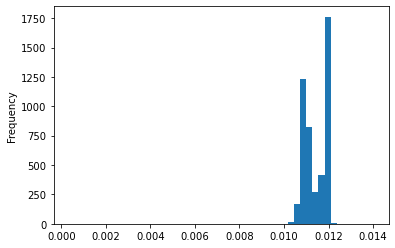

In [146]:
fore.plot.hist(bins=50)

<AxesSubplot:xlabel='inn,year'>

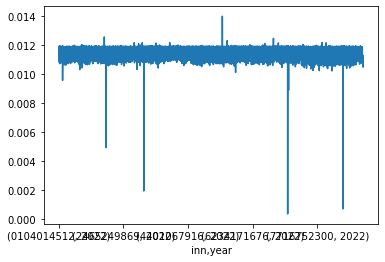

In [147]:
fore.plot.line()

In [51]:
from statsmodels.tsa.tsatools import lagmat
lagmat(pdf_Data.loc[idx[:, 2019], idx[:]], 1, trim='both', original='in', use_pandas=True)

,,ROA_par,Z_A_par,capital,Y,LOAN_par,ROA_par.L.1,Z_A_par.L.1,capital.L.1,Y.L.1,LOAN_par.L.1
inn,year,,,,,,,,,,
0105003792,2019,0.0036,0.002622,1.371600e+07,0.0,8.753333,0.0006,0.082383,2.495000e+06,0.0,8.753333
0105008695,2019,0.0110,0.044812,1.000000e+07,0.0,8.753333,0.0036,0.002622,1.371600e+07,0.0,8.753333
0105043900,2019,0.0408,0.030845,2.063000e+06,0.0,8.753333,0.0110,0.044812,1.000000e+07,0.0,8.753333
0106003795,2019,-0.0028,0.246559,3.200000e+07,0.0,8.753333,0.0408,0.030845,2.063000e+06,0.0,8.753333
0107008891,2019,0.0224,0.073343,1.000000e+04,0.0,8.753333,-0.0028,0.246559,3.200000e+07,0.0,8.753333
...,...,...,...,...,...,...,...,...,...,...,...
9705080114,2019,-0.0768,0.664638,2.500000e+06,0.0,8.753333,0.0074,0.436388,1.139981e+09,0.0,8.753333
9717048725,2019,0.0001,0.622920,2.100010e+09,0.0,8.753333,-0.0768,0.664638,2.500000e+06,0.0,8.753333
9718003519,2019,-0.0091,0.570066,1.011953e+09,0.0,8.753333,0.0001,0.622920,2.100010e+09,0.0,8.753333


In [61]:
# pdf_Data['roa_sh']=pdf_Data.groupby(level=0)['ROA_par'].shift(-1)
pdf_Data[['ROA_par_s', 'Z_A_par_s', 'LOAN_par_s']]=pdf_Data.groupby(level=0)[['ROA_par', 'Z_A_par', 'LOAN_par']].shift(1).dropna()
pdf_Data

ROA_par   Z_A_par       capital    Y   LOAN_par  ROA_par_s  \
inn        year                                                                
0104014512 2014 -0.042600  0.797872  1.000000e+04  0.0  11.135000        NaN   
           2015  0.004100  0.960739  1.000000e+04  0.0  15.716667  -0.042600   
           2016  0.001500  0.255651  1.000000e+04  0.0  12.592500   0.004100   
           2017  0.052300  0.190691  4.000000e+07  0.0  10.560000   0.001500   
           2018  0.001100  0.178391  4.000000e+07  0.0   8.866667   0.052300   
...                   ...       ...           ...  ...        ...        ...   
9729055420 2021  0.002250  0.033804  4.000020e+09  0.0   4.725591  -0.000749   
           2022  0.001202  0.031894  4.000020e+09  0.0   6.327573   0.002250   
           2023  0.002394  0.032195  4.000020e+09  0.0   6.569880   0.001202   
           2024  0.001658  0.032027  4.000020e+09  0.0   6.812186   0.002394   
           2025  0.001787  0.032027  4.000020e+09  0.0   6.626160   0.001658   

                 Z_A_par_s  LOAN_par_s  
inn        year                         
0104014512 2014        NaN         NaN  
           2015   0.797872   11.135000  
           2016   0.960739   15.716667  
           2017   0.255651   12.592500  
           2018   0.190691   10.560000  
...                    ...         ...  
9729055420 2021   0.050480    7.011111  
           2022   0.033804    4.725591  
           2023   0.031894    6.327573  
           2024   0.032195    6.569880  
           2025   0.032027    6.812186  

[55902 rows x 8 columns]

In [58]:
pdf_Data

ROA_par   Z_A_par       capital    Y   LOAN_par
inn        year                                                  
0104014512 2014 -0.042600  0.797872  1.000000e+04  0.0  11.135000
           2015  0.004100  0.960739  1.000000e+04  0.0  15.716667
           2016  0.001500  0.255651  1.000000e+04  0.0  12.592500
           2017  0.052300  0.190691  4.000000e+07  0.0  10.560000
           2018  0.001100  0.178391  4.000000e+07  0.0   8.866667
...                   ...       ...           ...  ...        ...
9729055420 2021  0.002250  0.033804  4.000020e+09  0.0   4.725591
           2022  0.001202  0.031894  4.000020e+09  0.0   6.327573
           2023  0.002394  0.032195  4.000020e+09  0.0   6.569880
           2024  0.001658  0.032027  4.000020e+09  0.0   6.812186
           2025  0.001787  0.032027  4.000020e+09  0.0   6.626160

[55902 rows x 5 columns]

#### Алгоритм счета:
Значения $ROA\_{par}^j, Z\_A\_{par}^j$ и $capital^j$ для всех компаний расчитаны в блокноте <a href="bankrupt_prob_DB.ipynb" target="_blank">"Расчет промежуточных моделей"</a> и беруться из базы данных (таблица model_data).   
Значения кредитной ставки $LOAN\_{par}^j$ на фактичском периоде так же беруться из базы данных (таблица model_data) - на этом периоде они обинаковы для всех компаний.

**По этим значениям, на фактических данных оценивается модель**

Далее, на прогнозном интервале предиктор `кредитная ставка для компании j` $r_i^j$ расчитывается так:
<br>
<center>$r_i^j = LOAN\_{par}_i^j+ φ*P\_(t+1)*(1-γ)*100$</center>

где 

<div style="background:AntiqueWhite">
 <h2> Оценка и расчет основной модели "Банкротства застройщиков"</h2>
 <br>
 <center>$Y$ ~ $ROA_{y-1} + Z\_A_{y-1} + LOAN_{y-1} + Ln(capital) + 1$</center>

 <b>Предикторы:</b>
 <ul>
 <li>Ставка по кредитам (<i>LOAN</i> с лагом 1 год)</li>
 <li>Рентабельность застройщика (<i>ROA</i> с лагом 1 год)</li>
 <li>Чистая кредиторская задолженность(<i>Z_A</i> с лагом 1 год)</li>
 <li>Уставной капитал, ln от тыс.руб.(<i>capital</i>)</li>
 </ul><br>
 <b>Объясняемая переменная</b> - флаг банкротства компании, устанавливаемый в год банкротства (<i>Y</i>)
 <br><br>
 Переменная <b>fBnkrp_Level</b> задает порог отсечки события (превышение порога - предприятие банкрот).
</div>

In [5]:
# bnkr_model = sm.GLM.from_formula("Y ~ ROA_ + Z_A_ + np.log(capital)", family=sm.families.Binomial(), data=pdf_X)
bnkr_model = smf.logit("Y ~ roa + z_a + np.log(capital)", data=pdf_XY)
bnkr_result = bnkr_model.fit()

print(bnkr_result.summary())

Optimization terminated successfully.
         Current function value: 0.077981
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                47147
Model:                          Logit   Df Residuals:                    47143
Method:                           MLE   Df Model:                            3
Date:                Wed, 16 Sep 2020   Pseudo R-squ.:                0.005295
Time:                        18:15:31   Log-Likelihood:                -3676.6
converged:                       True   LL-Null:                       -3696.2
Covariance Type:            nonrobust   LLR p-value:                 1.618e-08
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.5096      0.137    -25.560      0.000      -3.779      -3.240
roa           

In [6]:
pdf_XY['Y_p']=bnkr_result.predict()
pdf_XY

ValueError: Length of values (47147) does not match length of index (80954)

## Оценка и расчет основной модели "Банкротства застройщиков"
<br>
<center>$Y$ ~ $\overline{ROA}_{y-1} + \overline{Z\_A}_{y-1} + \overline{LOAN}_{y-1} + Ln(capital) + 1$</center>


<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Ставка по кредитам (<i>LOAN_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>
        <li>Медианная по отрасли рентабельность застройщика (<i>ROA_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>
        <li>Медианная по отрасли Чистая кредиторская задолженность(<i>Z_A_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>        
        <li>Уставной капитал, ln от тыс.руб.(<i>Capital</i> датафрейма <i>pdfSPARK</i>)</li>
    </ul><br>
    <b>Объясняемая переменная</b> - год банкротства компании (<i>Cancel_date</i> датафрейма <i>pdfSPARK</i>, ненулевая дата соответствует событию "банкротство")<br><br>
    Переменная <b>fBnkrp_Level</b> задает порог отсечки события (превышение порога - предприятие банкрот).
</div>

Для прогноза данные датафрейма `pdfSPARK` продлеваются (копируются построчно) на прогнозные года (данные беруться из последнего, максимального для всех записей года. 

Потом полученный датафрейм комбинируется с датафреймом `pdfSubModResult`  
При совпадении значений в полях `year` и года в `Cancel_date` в поле `Cancel_date` ставится `1` - индикатор события. Последующие года для даного `inn` в моделированиине участвуют - компания считается банкротом

<div class="alert alert-block alert-danger">
    <b>Надо бы еще сделать отсечку: если есть (либо фактическая, либо модельная) дата ликвидации, то для даной компании все строки, с датой больше даты ликвидации - удалить. То есть удалить все, что после банкротства</b>
    <br>
    <b>Еще наверное надо сделать прогноз (расчет y) - прогонять по годам. 2020, потом 2021 и т.д. И удалять всех банкротов из последующих годов.</b>
</div>

#### Строим модель банкротств



In [168]:
import statsmodels.formula.api as smf

# bnkr_model = sm.GLM.from_formula("Y ~ ROA_ + Z_A_ + np.log(capital)", family=sm.families.Binomial(), data=pdf_X)
bnkr_model = smf.logit("Y ~ ROA_ + Z_A_ + np.log(capital)", data=pdf_X)
bnkr_result = bnkr_model.fit()

print(bnkr_result.summary())

         Current function value: 0.046314
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                66862
Model:                          Logit   Df Residuals:                    66858
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Aug 2020   Pseudo R-squ.:                 0.05689
Time:                        19:39:00   Log-Likelihood:                -3096.7
converged:                      False   LL-Null:                       -3283.5
Covariance Type:            nonrobust   LLR p-value:                 1.153e-80
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -33.6472      3.115    -10.803      0.000     -39.752     -27.543
ROA_            -1937.0313    187.005    -10.358  

#### Проверка по историческим данным

Если в некотором годе вероятность банкротства по модели больше заданного уровня (`fBnkrp_Level`), компания считается банкротом (флаг Y_p устанавливается в 1)

In [169]:
pdf_X['Y_p']=(bnkr_result.predict(pdf_X)>=fBnkrp_Level).astype(int)
pdf_X

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
13,7701651356,2008,NaT,0.005350,0.174666,50000.0,0.0,0
15,7725038614,2008,NaT,0.005350,0.174666,12000.0,0.0,0
17,7714726658,2008,2020-07-21,0.005350,0.174666,10000.0,0.0,0
18,7807020417,2008,NaT,0.005350,0.174666,110000.0,0.0,0
20,7703037783,2008,NaT,0.005350,0.174666,4000.0,0.0,0
...,...,...,...,...,...,...,...,...
112627,6213013559,2020,NaT,0.002941,0.209570,80000000.0,0.0,0
112628,2221204292,2020,NaT,0.002941,0.209570,80000000.0,0.0,0
112629,7017342291,2020,NaT,0.002941,0.209570,50284000.0,0.0,0
112630,5603041609,2020,NaT,0.002941,0.209570,10000.0,0.0,1


#### Прогноза банкротств на заданный горизонт

In [170]:
i_start=dt.datetime.now().year
i_horizont=i_start+3

# bnkr_result.predict()
pdf_x['Y_p']=(bnkr_result.predict(pdf_x)>=fBnkrp_Level).astype(int)
pdf_x


,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
112653,3905610382,2021,2019-12-17,0.005940,0.191393,10000.0,0.0,0
112692,5530005074,2021,2020-03-23,0.005940,0.191393,10000.0,0.0,0
112718,5503031981,2021,2019-12-18,0.005940,0.191393,10000.0,0.0,0
112745,7723186303,2021,2020-07-02,0.005940,0.191393,10000.0,0.0,0
112767,7722535569,2021,2018-12-27,0.005940,0.191393,10000.0,0.0,0
...,...,...,...,...,...,...,...,...
155878,0816006455,2025,2020-01-28,0.005477,0.187667,10000.0,0.0,0
155879,7424031171,2025,2019-12-27,0.005477,0.187667,10000.0,0.0,0
155883,6140038767,2025,2020-04-30,0.005477,0.187667,20000.0,0.0,0
155938,7604068205,2025,2019-04-02,0.005477,0.187667,10000.0,0.0,0


In [171]:
pdf_x.loc[pdf_x['Y_p']==1]

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p


In [172]:

pdf_X.loc[(pdf_X['Y']!=0) & (pdf_X['Y_p']!=pdf_X['Y'])]

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
38814,2722057514,2012,2012-06-21,0.003000,0.196358,10000.0,1.0,0
63996,2012002172,2015,2015-07-13,0.001400,0.191316,12010000.0,1.0,0
65335,2315143895,2015,2015-09-17,0.001400,0.191316,100000.0,1.0,0
68678,6228040280,2015,2015-09-03,0.001400,0.191316,10200000.0,1.0,0
69790,6901024343,2016,2016-12-27,0.001100,0.190117,30678000.0,1.0,0
...,...,...,...,...,...,...,...,...
111893,8911001194,2020,2020-03-05,0.002941,0.209570,7609000.0,1.0,0
111950,5836662951,2020,2020-06-16,0.002941,0.209570,80000000.0,1.0,0
112318,6685010079,2020,2020-06-30,0.002941,0.209570,81500000.0,1.0,0
112534,6673150882,2020,2020-05-13,0.002941,0.209570,931370000.0,1.0,0


# Ниже - пробы

Можно строить регрессию по заданой формуле, не обязательно линейную, можно использовать любую питоновскюй функции, или встроенные, типа сплайнов

In [16]:
import patsy
import statsmodels.formula.api as smf

# resROA = sm.OLS(Y_roa, X_roa, missing='drop').fit()

# resROA.summary()

pdf=pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy()
pdf['ROA']=Y_roa

resROA_f = sm.OLS.from_formula(formula='ROA ~ I_nom_prices_sec_market + marga', missing='drop', data=pdf).fit()

resROA_f.summary()

/home/egor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.9513
Date:                Tue, 28 Jul 2020   Prob (F-statistic):              0.426
Time:                        19:38:20   Log-Likelihood:                 60.121
No. Observations:                  11   AIC:                            -114.2
Df Residuals:                       8   BIC:                            -113.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0122      0.010     -1.182      0.271      -0.036       0.012
I_nom_prices_sec_market     0.0080      0.007      1.211      0.261      -0.007       0.023
marga                       0.0049      0.004      1.106      0.301      -0.005       0.015
==============================================================================
Omnibus:                        0.481   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.424
Skew:                           0.377   Prob(JB):                        0.809
Kurtosis:                       2.404   Cond. No.                         65.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# pdfSPARK=pdfSPARK.loc[pdfSPARK[['capital', 'Cancel_date', 'ROA', 'Z_A']].dropna(how='all').index, :]
# pdfM=pdfSPARK.merge(pdfNoza, on='inn')
# pdfM.loc[pdfM['inn']=='5050102110']

In [ ]:
# pdfSPARK.loc[pdfSPARK['inn']=='6232001460']

In [ ]:
# pdfT=pd.read_sql('select * from spark', con=conWork)
# pdfT.loc[(pdfT['inn']=='6232001460')]

In [ ]:

# res.loc[idx[2015:2019, :], idx[:]]

<div class="alert alert-block alert-info">
<b>Для изменения данных в ручном режиме использовать шаблон</b>

</div>

```python
pdfXLS_model.loc[2010, 'I_nom_prices_sec_market'] = 0
```

pdfXLS_model.loc[<год>, <название нужной колонки или список колонок>] = <нужное значение или список значений>

In [ ]:
pdf['const']=1.0
model_indep = sm.GEE.from_formula(
    "rent_otr ~ marga + i_price",
    cov_struct = sm.cov_struct.Independence(),
    groups = 'const',
    data=pdf.reset_index()
    ).fit()
model_indep.summary()

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Store the url string that hosts our .csv file
# url = "Cartwheeldata.csv"

# Read the .csv file and store it as a pandas Data Frame
# df = pd.read_csv(url)

# Create Scatterplot
sns.lmplot(x='marga', y='i_price', data=pdf)

plt.show()

In [ ]:
# Scatterplot arguments
# sns.lmplot(x='Wingspan', y='CWDistance', data=df,
#            fit_reg=False, # No regression line
#            hue='Gender')   # Color by evolution stage

# plt.show()